In [1]:
import torch
import scipy
import torch.nn.functional as F
from model.model import MLP
from trainer.trainer import train_mlp
from data_loader.data_loader import simulation_data_loader

torch.set_default_tensor_type(torch.DoubleTensor)


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KDTree

import numpy as np
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import matplotlib.pyplot as plt


from scipy.stats import cauchy





In [2]:
SEED = 123
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)

## Motivation

In [3]:


d=100
n_train=10000
n_test=20000
learning_rate=0.5

kargs={"max_iteration":2000,"lamda_1":0.1}





loss_fn=torch.nn.MSELoss()
model=MLP(d)
data_loader=simulation_data_loader(d,n_train,n_test)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[700,1500], gamma=0.5)


trained_model=train_mlp(model, data_loader,loss_fn,optimizer,scheduler,**kargs)




loss:0.013773547336742017,iter:0
loss:0.008709028634584769,iter:100
loss:0.007091253984404402,iter:200
loss:0.005437244062103142,iter:300
loss:0.004148372816634768,iter:400
loss:0.003245941346704014,iter:500
loss:0.0025908565151022654,iter:600
loss:0.0022209617939946986,iter:700
loss:0.0019891988486377874,iter:800
loss:0.0017657847270919679,iter:900
loss:0.0016507422730399918,iter:1000
loss:0.001551809713593586,iter:1100
loss:0.0014628036613662308,iter:1200
loss:0.001377906964524065,iter:1300
loss:0.001300826070490077,iter:1400
loss:0.0012383545032957116,iter:1500
loss:0.0011975942103760661,iter:1600
loss:0.0011729141607759639,iter:1700
loss:0.0011503520432529606,iter:1800
loss:0.0011295825738818607,iter:1900


In [4]:
X_test,y_test=data_loader.get_test_data()
pred=trained_model(X_test)[0]

In [5]:
pred=pred.detach().numpy().ravel()
y_test=y_test.numpy()

In [12]:
outlier_idx=np.linalg.norm(X_test,axis=1)>20
inlier_idx=np.linalg.norm(X_test,axis=1)<=20

In [13]:
((pred-y_test)**2).mean()
((pred[outlier_idx]-y_test[outlier_idx])**2).mean()
((pred[inlier_idx]-y_test[inlier_idx])**2).mean()

0.006925942052243673

0.18502742260410093

0.0009051435264029481

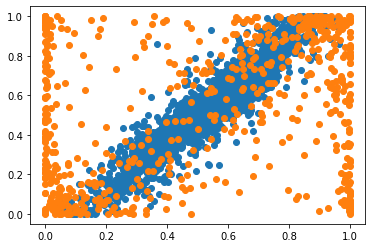

In [14]:
plt.scatter(pred[inlier_idx],y_test[inlier_idx])

plt.scatter(pred[outlier_idx],y_test[outlier_idx])


## ANN

In [18]:
class feature_extractor(torch.nn.Module):
    def __init__(self,d):
        super(feature_extractor, self).__init__()
        torch.manual_seed(666)
        self.linear1 = torch.nn.Linear(d,200)
        self.linear2 = torch.nn.Linear(200,50)
        self.linear3 = torch.nn.Linear(50,20)
 

    def forward(self, x):
        layer1_out = torch.relu(self.linear1(x))
        layer2_out = torch.relu(self.linear2(layer1_out))
        out = torch.sigmoid(self.linear3(layer2_out))
        
        return out

In [4]:
def find_lamda(beta):
    potentialNeighbors=len(beta)
    alphaIndexMax=0
    lamda = beta[0]+1 
    Sum_beta = 0
    Sum_beta_square = 0
    while ( lamda>beta[alphaIndexMax] ) and (alphaIndexMax<potentialNeighbors-1):
        # update max index
        alphaIndexMax +=1
        # updata sum beta and sum beta square
        Sum_beta += beta[alphaIndexMax-1]
        Sum_beta_square += (beta[alphaIndexMax-1])**2
        
        # calculate lambda
        
        if  alphaIndexMax  + (Sum_beta**2 - alphaIndexMax * Sum_beta_square)>=0:
                
            
            lamda = (1/alphaIndexMax) * ( Sum_beta + torch.sqrt( alphaIndexMax  + (Sum_beta**2 - alphaIndexMax * Sum_beta_square) ) )
            
        else:
            alphaIndexMax-=1
            break
    return lamda

In [5]:

def train_ann(model, data_loader,loss_fn,optimizer,scheduler,**kargs):
    
    X_train,y_train=data_loader.get_train_data()
    
 

    loss_curve=[]
    # loop for max_iteration times
    for t in range(kargs["max_iteration"]):
        
        # renew optimizer
        optimizer.zero_grad(set_to_none=True)
        # forward propagate
        out1= model(X_train)
        out2= model(X_train)
       
  
        
        loss = loss_fn(out1, out2, y_train,y_train,kargs["C"] )
        if t % 10==0:
            print("loss:{},iter:{}".format(loss.item(),t))
        # record loss
        loss_curve.append(loss.item())
        
        
        
        loss.backward()
        
        # gradient descent
        optimizer.step()
        # learning rate decay
        scheduler.step()
    
    return model

In [12]:
def awnn_loss(output_train,ouput_test,y_train,y_test,C):
    
    mse_loss=0
    for idx_test_instance,test_instance in enumerate(ouput_test):
        distance=torch.cdist(test_instance.reshape(1,-1),output_train)[0]

        #non_zero_idx=torch.where(distance>0)[0]
        #y_train_used=y_train[non_zero_idx]
        #distance=distance[non_zero_idx]

        
        beta,_=torch.sort(distance)
        beta=C*beta.detach()
        lamda=find_lamda(beta)

        
        weight=torch.relu(lamda-C*distance)
        mse_loss+=weight.sum()
        
        
        normalized_weight=weight/weight.sum()
        
        pred=normalized_weight.dot(y_train)
        mse_loss+=(pred-y_test[idx_test_instance])**2
       

    return mse_loss

    

        

In [26]:

d=10
n_train=100
n_test=20
learning_rate=0.5


kargs={"max_iteration":150,"C":0.1}



loss_fn=awnn_loss
model=feature_extractor(d)
data_loader=simulation_data_loader(d,n_train,n_test)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[500,1000], gamma=0.5)

trained_feature_extractor=train_ann(model, data_loader,loss_fn,optimizer,scheduler,**kargs)

loss:998.9050342351957,iter:0
loss:997.0216683031468,iter:10
loss:997.0216683031468,iter:20


KeyboardInterrupt: 

In [24]:
out_feature=trained_feature_extractor(data_loader.get_test_data()[0])